## Assignment 2 - Exploration of patterns in the data

### Energy Demand based on time data

Energy Demand (Regression): Heavily dependant on seasonal patterns (time-of-day, day-of-week, time-of-year), and partly on weather

Descriptive model : Model the relationship between time and demand
Predictive model : Since predicting the time as a given time in the future is trivial, this is almost for free. Different types include Long-term Load Forecasting (months-ahead), Short-term Load Forecasting (day-head or week-ahead), and Ultra Short-term Load Forecasting (hours-ahead).

I have decided explore demand as a function of time features. I will first look at the 

In [1]:
# import what has to be
from influxdb import InfluxDBClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from energy_gen_forecast import mytransformers
plt.style.use('seaborn')
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [2]:
# create client
client = InfluxDBClient(host = 'influxus.itu.dk', port = 8086, username = 'lsda', password = 'icanonlyread')
client.switch_database('orkney')

In [3]:
client.get_list_measurements()

[{'name': 'ANM_Operation'},
 {'name': 'Demand'},
 {'name': 'Generation'},
 {'name': 'Generator_Site_Issues'},
 {'name': 'SHEPD_Equipment'},
 {'name': 'Temperature'},
 {'name': 'Wind'}]

In [4]:
# get demand data for exploration
results = client.query('SELECT Total FROM "Demand" WHERE time > now() - 200w')
points = results.get_points()
values = results.raw['series'][0]["values"]
columns = results.raw['series'][0]["columns"]
demand_df = pd.DataFrame(values, columns = columns).set_index("time")

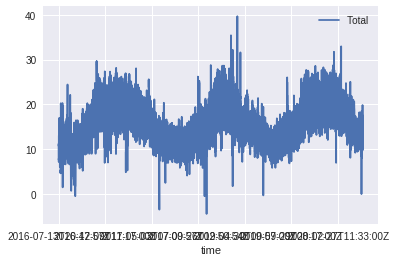

In [5]:
demand_df.plot()

In [6]:
demand_df.head()

,Total
time,
2016-07-13T20:47:57Z,10.7
2016-07-13T20:48:57Z,10.7
2016-07-13T20:49:57Z,10.7
2016-07-13T20:50:57Z,10.7
2016-07-13T20:51:57Z,10.7


In [7]:
results = client.query('SELECT mean(Total) FROM "Demand" WHERE time > now() - 200w GROUP BY time(1h)')
points = results.get_points()
values = results.raw['series'][0]["values"]
columns = results.raw['series'][0]["columns"]
demand_mean_df = pd.DataFrame(values, columns = columns).set_index("time")

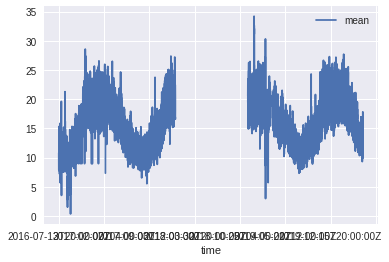

In [8]:
demand_mean_df.plot()

## Preprocessing Pipeline

In [9]:
# preprocessing pipeline
pre_pipeline = Pipeline([
    ('date_worker', mytransformers.DateTransformer()),
    ('shifter', mytransformers.Shifter())
])

In [10]:
# apply pipeline
processed_data = pre_pipeline.fit_transform(demand_df, shifter__days = 7)
features = processed_data[0]
labels = processed_data[0]

In [11]:
features.head()

,time,Total,year,month,day,hour,minute,day_of_week,1dayback,2dayback,3dayback,4dayback,5dayback,6dayback,7dayback
datetime,,,,,,,,,,,,,,,
2018-12-07 11:40:00,2018-12-07T11:40:00Z,21.30,2018,12,7,11,40,4,21.87,22.54,22.93,19.98,20.98,19.55,20.54
2018-12-07 11:50:00,2018-12-07T11:50:00Z,21.62,2018,12,7,11,50,4,21.61,22.51,23.15,20.96,20.92,18.89,20.59
2018-12-07 12:00:00,2018-12-07T12:00:00Z,22.27,2018,12,7,12,0,4,22.37,22.90,23.92,21.15,21.60,20.54,21.50
2018-12-07 12:10:00,2018-12-07T12:10:00Z,23.73,2018,12,7,12,10,4,24.26,25.22,25.86,22.49,23.59,21.87,22.59
2018-12-07 12:20:00,2018-12-07T12:20:00Z,23.29,2018,12,7,12,20,4,23.82,24.58,25.36,22.11,22.83,21.30,22.53


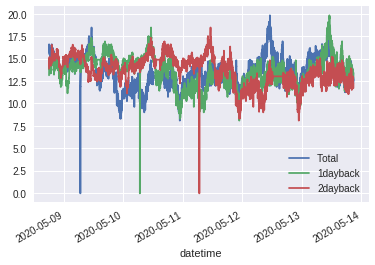

In [12]:
features[['Total', '1dayback', '2dayback']].iloc[-7000:].plot()
plt.savefig('1dayback.png')

In [13]:
trustworthy_test_df = features.groupby(['year', 'month', 'day', 'hour']).count()

In [14]:
trustworthy_test_df[trustworthy_test_df['minute'] != 60]

time  Total  minute  day_of_week  1dayback  2dayback  \
year month day hour                                                         
2018 12    7   11       2      2       2            2         2         2   
               12       6      6       6            6         6         6   
               13       6      6       6            6         6         6   
               14       6      6       6            6         6         6   
               15       6      6       6            6         6         6   
...                   ...    ...     ...          ...       ...       ...   
2020 5     13  1       34     34      34           34        34        34   
               2       16     16      16           16        16        16   
               3       59     59      59           59        59        59   
               18      58     58      58           58        58        58   
               20      48     48      48           48        48        48   

                     3dayback  4dayback  5dayback  6dayback  7dayback  
year month day hour                                                    
2018 12    7   11           2         2         2         2         2  
               12           6         6         6         6         6  
               13           6         6         6         6         6  
               14           6         6         6         6         6  
               15           6         6         6         6         6  
...                       ...       ...       ...       ...       ...  
2020 5     13  1           34        34        34        34        34  
               2           16        16        16        16        16  
               3           59        59        59        59        59  
               18          58        58        58        58        58  
               20          48        48        48        48        48  

[3213 rows x 11 columns]

In [15]:
trustworthy_test_df[trustworthy_test_df['minute'] == 60]

time  Total  minute  day_of_week  1dayback  2dayback  \
year month day hour                                                         
2019 4     3   13      60     60      60           60        60        60   
               14      60     60      60           60        60        60   
               15      60     60      60           60        60        60   
               16      60     60      60           60        60        60   
               17      60     60      60           60        60        60   
...                   ...    ...     ...          ...       ...       ...   
2020 5     13  14      60     60      60           60        60        60   
               15      60     60      60           60        60        60   
               16      60     60      60           60        60        60   
               17      60     60      60           60        60        60   
               19      60     60      60           60        60        60   

                     3dayback  4dayback  5dayback  6dayback  7dayback  
year month day hour                                                    
2019 4     3   13          60        60        60        60        60  
               14          60        60        60        60        60  
               15          60        60        60        60        60  
               16          60        60        60        60        60  
               17          60        60        60        60        60  
...                       ...       ...       ...       ...       ...  
2020 5     13  14          60        60        60        60        60  
               15          60        60        60        60        60  
               16          60        60        60        60        60  
               17          60        60        60        60        60  
               19          60        60        60        60        60  

[6808 rows x 11 columns]

So most of the time it is correct, but I don't think I can trust this.

## Explorations

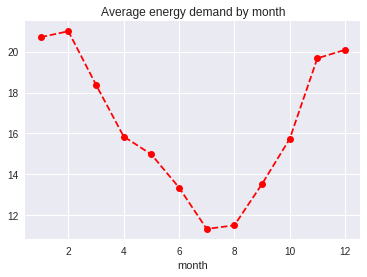

In [16]:
# plot average year
features.groupby(['month']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by month')
plt.savefig('monthly_seasonality.png')

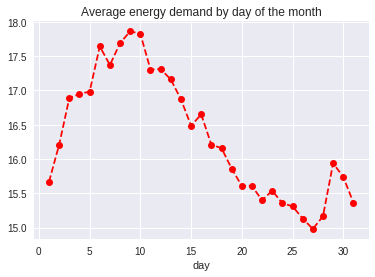

In [17]:
# plot average month
features.groupby(['day']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by day of the month')
plt.savefig('daily_seasonality.png')

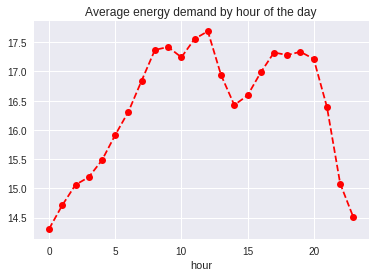

In [18]:
# plot average day
features.groupby(['hour']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by hour of the day')
plt.savefig('hourly_seasonality.png')

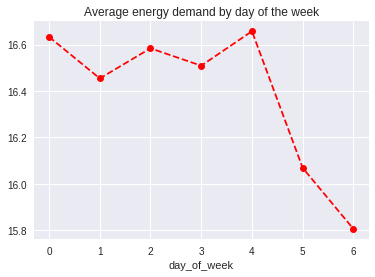

In [19]:
features.groupby(['day_of_week']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by day of the week')
plt.savefig('weekly_seasonality.png')

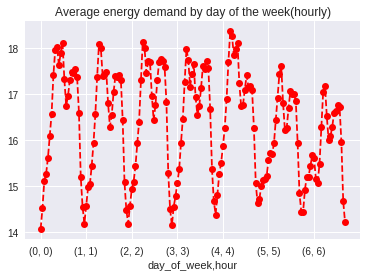

In [20]:
features.groupby(['day_of_week', 'hour']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by day of the week(hourly)')
plt.savefig('weekly_seasonality_hours.png')

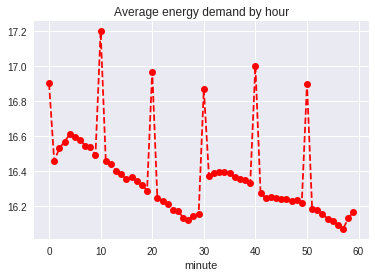

In [21]:
# plot average hour
features.groupby(['minute']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by hour')
plt.savefig('hourly_seasonality.png')

# Is the hourly mean far off from the values

In [22]:
demand_hourly_mean_df = features.groupby(['year', 'month', 'day', 'hour']).mean()['Total']
#for i in range(4)[::-1]:
#    demand_hourly_mean_df = demand_hourly_mean_df.reset_index(level = i)

In [23]:
demand_hourly_mean_df

year  month  day  hour
2018  12     7    11      21.460000
                  12      22.950000
                  13      21.811667
                  14      20.203333
                  15      21.683333
                            ...    
2020  5      13   16      13.368333
                  17      12.188667
                  18      12.500345
                  19      13.983500
                  20      12.913750
Name: Total, Length: 10021, dtype: float64

In [24]:
demand_hourly_std_df = features.groupby(['year', 'month', 'day', 'hour']).std()['Total']

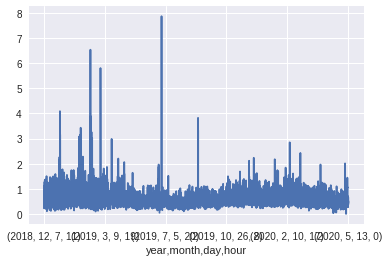

In [25]:
demand_hourly_std_df.plot()

In [26]:
mean_diff_df = features.reset_index(level = 0).set_index(['year', 'month', 'day', 'hour']).join(demand_hourly_mean_df, rsuffix= 'm_')

In [27]:
mean_diff_df['diff_from_mean'] = mean_diff_df['Total'] - mean_diff_df['Totalm_']

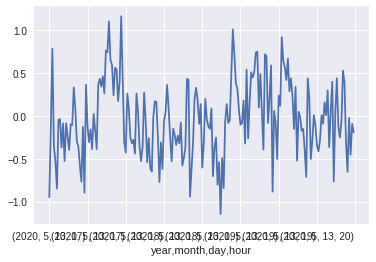

In [28]:
mean_diff_df['diff_from_mean'].iloc[-200:].plot()

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [30]:
mean_absolute_error(mean_diff_df['Total'], mean_diff_df['Totalm_'])

0.4584917488888719

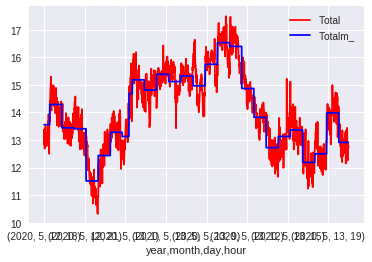

In [31]:
mean_diff_df[['Total', 'Totalm_']].iloc[-1500:].plot(color = ['r', 'b'])
plt.savefig('hourly_mean_vs_actual.png')

In [32]:
np.sqrt(mean_squared_error(mean_diff_df['Total'], mean_diff_df['Totalm_']))

0.608311858436986

In [33]:
for i in range(4)[::-1]:
    demand_hourly_mean_df = demand_hourly_mean_df.reset_index(level = i)
demand_hourly_mean_df

,year,month,day,hour,Total
0,2018,12,7,11,21.460000
1,2018,12,7,12,22.950000
2,2018,12,7,13,21.811667
3,2018,12,7,14,20.203333
4,2018,12,7,15,21.683333
...,...,...,...,...,...
10016,2020,5,13,16,13.368333
10017,2020,5,13,17,12.188667
10018,2020,5,13,18,12.500345
10019,2020,5,13,19,13.983500


In [5]:
mean_pipeline = Pipeline([
    ('date_worker', mytransformers.DateTransformer()),
    ('aggregator', mytransformers.HourlyAggregator()),
    ('shifter', mytransformers.Shifter())
])

In [6]:
mean_processed = mean_pipeline.fit_transform(demand_df, shifter__days = 7)

In [9]:
mean_processed[0].head(72)

,year,month,day,hour,Total,day_of_week,1dayback,2dayback,3dayback,4dayback,5dayback
datetime,,,,,,,,,,,
2016-07-18 21:00:00,2016,7,18,21,10.833220,0,11.024138,12.127119,11.927500,12.228000,10.066774
2016-07-18 22:00:00,2016,7,18,22,11.137931,0,11.414068,12.308500,11.677368,12.395263,10.511552
2016-07-18 23:00:00,2016,7,18,23,10.360556,0,8.081296,11.181525,10.525167,11.283000,10.030000
2016-07-19 00:00:00,2016,7,19,0,9.876140,1,8.006538,11.613559,11.128333,11.254407,9.771667
2016-07-19 01:00:00,2016,7,19,1,9.304035,1,7.933704,11.436441,10.674561,11.117966,9.230169
...,...,...,...,...,...,...,...,...,...,...,...
2016-07-21 16:00:00,2016,7,21,16,10.975500,3,12.535000,8.768667,11.886833,8.654468,12.797966
2016-07-21 17:00:00,2016,7,21,17,11.018596,3,12.683529,8.709833,12.668475,9.495965,12.740500
2016-07-21 18:00:00,2016,7,21,18,10.130333,3,12.188136,8.225932,12.653500,10.356038,12.416167


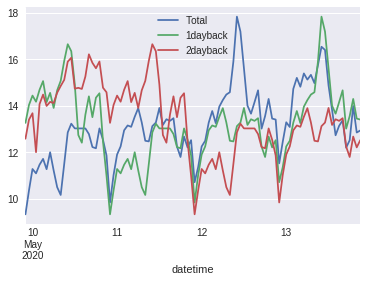

In [14]:
mean_processed[0][['Total', '1dayback', '2dayback']].iloc[-96:].plot()